In [1]:
import tensorflow as tf 
import numpy as np 
from tensorflow import keras 
import os 
import math 
import random 
import pickle 
import glob
import matplotlib.pyplot as plt 
from collections import deque 
from tensorflow.keras import layers
import time 

from vehicle_model_original import Environment 
from cell_model import CellModel 
from driver_MDP import Driver_MDP 

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

-30627.831470329067


In [2]:
drving_cycle = '../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat'
battery_path = "../../OC_SIM_DB/OC_SIM_DB_Bat/OC_SIM_DB_Bat_nimh_6_240_panasonic_MY01_Prius.mat"
motor_path = "../../OC_SIM_DB/OC_SIM_DB_Mot/OC_SIM_DB_Mot_pm_95_145_X2.mat"
cell_model = CellModel()
# env = Environment(cell_model, drving_cycle, battery_path, motor_path, 10)
driver = Driver_MDP(0.02)

num_states = 4

In [3]:
class OUActionNoise: 
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None): 
        self.theta = theta 
        self.mean = mean 
        self.std_dev = std_deviation 
        self.dt = dt 
        self.x_initial = x_initial 
        self.reset() 
        
    def reset(self): 
        if self.x_initial is not None: 
            self.x_prev = self.x_initial 
        else: 
            self.x_prev = 0 
            
    def __call__(self): 
        x = (
             self.x_prev + self.theta * (self.mean - self.x_prev) * self.dt 
            + self.std_dev * np.sqrt(self.dt) * np.random.normal() 
        )
        self.x_prev = x 
        return x 

In [4]:
class Buffer: 
    def __init__(self, buffer_capacity=100000, batch_size=64):      
        self.buffer_capacity = buffer_capacity 
        self.batch_size = batch_size 
        self.buffer_counter = 0 
        
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, 1))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        
    def record(self, obs_tuple):
        index = self.buffer_counter % self.buffer_capacity 

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        
        self.buffer_counter += 1 
        
    def learn(self): 
        record_range = min(self.buffer_counter, self.buffer_capacity)
        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        
        with tf.GradientTape() as tape: 
            target_actions = target_actor(next_state_batch)
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions])
            critic_value = critic_model([state_batch, action_batch])
            critic_loss = tf.math.reduce_mean(tf.square(y - critic_value)) 
        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables) 
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )
        
        with tf.GradientTape() as tape: 
            actions = actor_model(state_batch)
            critic_value = critic_model([state_batch, actions])
            actor_loss = - tf.math.reduce_mean(critic_value)
        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables) 
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )
        

In [5]:
def update_target(tau): 
    new_weights = [] 
    target_variables = target_critic.weights
    for i, variable in enumerate(critic_model.weights): 
        new_weights.append(target_variables[i] * (1 - tau) + tau * variable)
    target_critic.set_weights(new_weights)
    
    new_weights = [] 
    target_variables = target_actor.weights
    for i, variable in enumerate(actor_model.weights): 
        new_weights.append(target_variables[i] * (1 - tau) + tau * variable)
    target_actor.set_weights(new_weights)
    

In [6]:
def get_actor(): 
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    
    inputs = layers.Input(shape=(num_states))
    inputs_batchnorm = layers.BatchNormalization()(inputs)
    
    out = layers.Dense(512, activation="relu")(inputs_batchnorm)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1, activation="sigmoid", 
                          kernel_initializer=last_init)(out)
    model = tf.keras.Model(inputs, outputs)
    return model

In [7]:
def get_critic(): 
    state_input = layers.Input(shape=(num_states))
    state_input_batchnorm = layers.BatchNormalization()(state_input)
    
    state_out = layers.Dense(16, activation="relu")(state_input_batchnorm)
#     state_out = layers.BatchNormalization()(state_out)
    state_out = layers.Dense(32, activation="relu")(state_out)
#     state_out = layers.BatchNormalization()(state_out)
    
    action_input = layers.Input(shape=(1))
    action_out = layers.Dense(32, activation="relu")(action_input)
#     action_out = layers.BatchNormalization()(action_out)
    
    concat = layers.Concatenate()([state_out, action_out]) 
    
    out = layers.Dense(512, activation="relu")(concat)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1)(out)
    
    model = tf.keras.Model([state_input, action_input], outputs)
    return model 
    

In [8]:
def policy(state, noise_object): 
    j_min = state[0][2].numpy()
    j_max = state[0][3].numpy()
    sampled_action = tf.squeeze(actor_model(state)) 
    noise = noise_object()
    sampled_action = sampled_action.numpy() + noise 
    legal_action = sampled_action * j_max 
    legal_action = np.clip(legal_action, j_min, j_max)
#     print(j_min, j_max, legal_action, noise)
    return legal_action 
    

In [9]:
def policy_epsilon_greedy(state, eps): 
    j_min = state[0][-2].numpy()
    j_max = state[0][-1].numpy()

    if random.random() < eps: 
        a = random.randint(0, 9)
        return np.linspace(j_min, j_max, 10)[a]
    else: 
        sampled_action = tf.squeeze(actor_model(state)).numpy()  
        legal_action = sampled_action * j_max 
        legal_action = np.clip(legal_action, j_min, j_max)
        return legal_action

In [10]:
std_dev = 0.2 
ou_noise = OUActionNoise(mean=0, std_deviation=0.2)

critic_lr = 0.0005 
actor_lr = 0.00025 
critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 300 
gamma = 0.95 
tau = 0.001 

MAX_EPSILON = 1.0 
MIN_EPSILON = 0.01 
DECAY_RATE = 0.00002
BATCH_SIZE = 32 
DELAY_TRAINING = 5000 

In [11]:
def initialization(): 
    actor_model = get_actor() 
    critic_model = get_critic() 
    target_actor = get_actor() 
    target_critic = get_critic() 
    target_actor.set_weights(actor_model.get_weights())
    target_critic.set_weights(critic_model.get_weights())
#     actor_model.load_weights("./DDPG1_trial1/actor_model_checkpoint")
#     critic_model.load_weights("./DDPG1_trial1/critic_model_checkpoint")
#     target_actor.load_weights("./DDPG1_trial1/target_actor_checkpoint")
#     target_critic.load_weights("./DDPG1_trial1/target_critic_checkpoint")
    
    buffer = Buffer(500000, BATCH_SIZE)
    return actor_model, critic_model, target_actor, target_critic, buffer

In [12]:
def save_weights(actor_model, critic_model, target_actor, target_critic, root): 
    actor_model.save_weights("./{}/actor_model.h5".format(root))
    critic_model.save_weights("./{}/critic_model.h5".format(root))
    target_actor.save_weights("./{}/target_actor.h5".format(root))
    target_critic.save_weights("./{}/target_critic.h5".format(root))
    print("model is saved..")

In [13]:
def initialization_env(driving_path, reward_factor):
    env = Environment(cell_model, driving_path, battery_path, motor_path, reward_factor)
    return env 

In [14]:
def test_agent(actor_model, reward_factor):
    test_cycle = driver.get_cycle() 
    env = initialization_env(test_cycle, reward_factor)
    
    total_reward = 0
    state = env.reset() 
    while True: 
        tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
        action = policy_epsilon_greedy(tf_state, -1)
        next_state, reward, done = env.step(action)
        
        state = next_state 
        total_reward += reward 
        
        if done: 
            break 
        
    SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
    
    print("******************* Test is start *****************")
#     print(test_cycle)
    print('Total reward: {}'.format(total_reward), 
          "SOC: {:.4f}".format(env.SOC), 
          "Cumulative_SOC_deviation: {:.4f}".format(SOC_deviation_history), 
          "Fuel Consumption: {:.4f}".format(env.fuel_consumption))
    print("******************* Test is done *****************")
    print("")
    plt.subplot(1, 2, 1)
    plt.plot(test_cycle)
    plt.subplot(1, 2, 2)
    plt.plot(env.history["Action"])
    plt.show() 
    return env.history  
    


Trial 0



C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization_MDP_environment\vehicle_model_original.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization_MDP_environment\vehicle_model_original.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 9.122
Episode: 1 Exploration P: 1.0000 Total reward: -3602.991568269222 SOC: 1.0000 Cumulative_SOC_deviation: 351.7392 Fuel Consumption: 85.5994

maximum steps, simulation is done ... 
elapsed_time: 8.315
Episode: 2 Exploration P: 1.0000 Total reward: -3567.6120973071306 SOC: 1.0000 Cumulative_SOC_deviation: 348.7288 Fuel Consumption: 80.3243

Available condition is not avail... SOC: 0.9860685660911964, P_stack_set: [1.22897588e+00 1.19869422e+04 2.34705471e+04 3.45955527e+04
 4.53876540e+04 5.58509191e+04 6.59782805e+04 7.57551171e+04
 8.51610619e+04 9.41711648e+04], P_battery_set: [ -27426.05715767  -39411.77041227  -50895.37529626  -62020.38085282
  -72812.48214829  -83275.7472714   -93403.10867551 -103179.94530536
 -112585.89005609 -121595.99295356]
elapsed_time: 5.505
Episode: 3 Exploration P: 1.0000 Total reward: -3236.4683432785796 SOC: 0.9861 Cumulative_SOC_deviation: 217.6105 Fuel Consumption: 64.5856

maximum steps, simulat

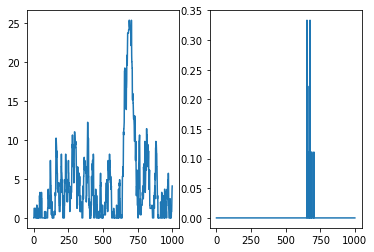

maximum steps, simulation is done ... 
elapsed_time: 53.811
Episode: 11 Exploration P: 0.9120 Total reward: -3535.8640491104616 SOC: 1.0000 Cumulative_SOC_deviation: 346.3743 Fuel Consumption: 72.1213



C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization_MDP_environment\vehicle_model_original.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (


Available condition is not avail... SOC: 0.9070751709763124, P_stack_set: [1.22897588e+00 1.19869422e+04 2.34705471e+04 3.45955527e+04
 4.53876540e+04 5.58509191e+04 6.59782805e+04 7.57551171e+04
 8.51610619e+04 9.41711648e+04], P_battery_set: [ -34934.04206822  -46919.75532283  -58403.36020681  -69528.36576338
  -80320.46705885  -90783.73218196 -100911.09358607 -110687.93021592
 -120093.87496664 -129103.97786412]
elapsed_time: 12.344
Episode: 12 Exploration P: 0.9079 Total reward: -1395.0357588886186 SOC: 0.9071 Cumulative_SOC_deviation: 36.8749 Fuel Consumption: 29.3962

maximum steps, simulation is done ... 
elapsed_time: 61.326
Episode: 13 Exploration P: 0.8901 Total reward: -3469.2178582795495 SOC: 0.9949 Cumulative_SOC_deviation: 339.6207 Fuel Consumption: 73.0113

Available condition is not avail... SOC: 0.999345764007702, P_stack_set: [1.22897588e+00 1.19869422e+04 2.34705471e+04 3.45955527e+04
 4.53876540e+04 5.58509191e+04 6.59782805e+04 7.57551171e+04
 8.51610619e+04 9.41711

KeyboardInterrupt: 

In [15]:
# print(env.version)

num_trials = 1
results_dict = {} 
# driving_cycle_paths = glob.glob("../data/driving_cycles/city/*.mat")[:1]

for trial in range(num_trials): 
    print("")
    print("Trial {}".format(trial))
    print("")
    
    actor_model, critic_model, target_actor, target_critic, buffer = initialization()
    
    eps = MAX_EPSILON 
    steps = 0
    
    episode_rewards = [] 
    episode_SOCs = [] 
    episode_FCs = [] 
    episode_test_history = [] 
    episode_num_test = [] 
    for ep in range(total_episodes): 
        
        driving_cycle = driver.get_cycle() 
        env = initialization_env(driving_cycle, 10)
        
        start = time.time() 
        state = env.reset() 
        episodic_reward = 0 

        while True: 
            tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
            action = policy_epsilon_greedy(tf_state, eps)
    #         print(action)
            next_state, reward, done = env.step(action)
            if done: 
                next_state = [0] * num_states 

            buffer.record((state, action, reward, next_state))
            episodic_reward += reward 

            if steps > DELAY_TRAINING: 
                buffer.learn() 
                update_target(tau)
                eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp(-DECAY_RATE * (steps
                                                                        -DELAY_TRAINING))

            steps += 1

            if done: 
                break 

            state = next_state 

        elapsed_time = time.time() - start 
        print("elapsed_time: {:.3f}".format(elapsed_time))
        episode_rewards.append(episodic_reward) 
        episode_SOCs.append(env.SOC)
        episode_FCs.append(env.fuel_consumption) 

    #     print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
        SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
        print(
              'Episode: {}'.format(ep + 1),
              "Exploration P: {:.4f}".format(eps),
              'Total reward: {}'.format(episodic_reward), 
              "SOC: {:.4f}".format(env.SOC), 
              "Cumulative_SOC_deviation: {:.4f}".format(SOC_deviation_history), 
              "Fuel Consumption: {:.4f}".format(env.fuel_consumption), 
        )
        print("")
        
        if (ep + 1) % 10 == 0: 
            history = test_agent(actor_model, 10)
            episode_test_history.append(history) 
            episode_num_test.append(ep + 1)
            
    root = "DDPG_original_trained"
    save_weights(actor_model, critic_model, target_actor, target_critic, root)
    
    results_dict[trial + 1] = {
        "rewards": episode_rewards, 
        "SOCs": episode_SOCs, 
        "FCs": episode_FCs, 
        "test_history": episode_test_history, 
        "test_episode_num": episode_num_test, 
    }

In [ ]:
with open("DDPG_original.pkl", "wb") as f: 
    pickle.dump(results_dict, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# results_dict